### Performing checks for the resources available

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!nvidia-smi

Sat Jan  9 11:35:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installing huggingface transformers library

In [ ]:
!pip install transformers 

     |████████████████████████████████| 1.5MB 17.5MB/s 
     |████████████████████████████████| 890kB 52.8MB/s 
     |████████████████████████████████| 2.9MB 55.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4a7c2cb507361253b45fefb7af128373a802e796dc8521453e49478d2eeb88b2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Importing necessary packages

In [ ]:
import pandas as pd
import numpy as np 
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup 
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Importing dataset directories

In [ ]:
from os import getcwd , listdir 
from os.path import join
curr_dir = getcwd()
drive_dir = join(curr_dir , 'drive','MyDrive')
dataset_dir = join(drive_dir,'Codalab','Offensive Language Identification','Dataset')

In [ ]:
listdir(dataset_dir)

['mal_full_offensive_train_corrected.csv',
 'mal_full_offensive_dev_corrected.csv',
 'kannada_offensive_dev_corrected.csv',
 'kannada_offensive_train_corrected.csv',
 'tamil_offensive_full_train_corrected.csv',
 'tamil_offensive_full_dev_corrected.csv',
 'tamil_offensive_full_test.csv',
 'mal_full_offensive_test.csv',
 'kannada_offensive_test.csv',
 '0010.png']

## Loading training data

In [ ]:
train_df_path = join(dataset_dir,'tamil_offensive_full_train_corrected.csv')
# Load the dataset into a pandas dataframe.
train_df = pd.read_csv(train_df_path)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
train_df.sample(10)

Number of training sentences: 35,139



,text,label
19484,Naan arasiyaluku varuvathu uruthi..... Ithu 1996,Not_offensive
34941,d grade cheyan nokuna ella myranmarodum parayu...,not-Tamil
31609,நான்..நாடார்... இந்த...விசிகவினர்..தலித்..இளைஞ...,Not_offensive
4342,Innum neraiya neraiya neraiya neraiya neraiya ...,Not_offensive
26624,Enda 61000 per aduthavanuku viswawatha katta p...,Not_offensive
428,Sema thala thala thala mass ha erukku,Not_offensive
27171,Cell phone aakathuna Apparam yathuku? Mobile t...,Offensive_Untargetede
11388,Hey Vijay darling sir enga ena pandraru???🤗🤗🤗,Not_offensive
24552,BGM missing not powerful like SANA,Not_offensive
7567,NEXT DEEPAWALI KU SARA VEDI,Not_offensive


In [ ]:
train_df['label'].value_counts()

Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: label, dtype: int64

In [ ]:

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])

In [ ]:
train_df['label'].value_counts()

0    25425
4     2906
1     2557
2     2343
5     1454
3      454
Name: label, dtype: int64

### Loading `train_sentences` and `train_labels`

In [ ]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['label'].values

## Saving Class Names

In [ ]:
class_names = [
               'Not_offensive','Offensive_Targeted_Insult_Group','Offensive_Targeted_Insult_Individual',
               'Offensive_Targeted_Insult_Other','Offensive_Untargetede','not-Tamil'          
]

## Loading the validation data

In [ ]:
val_df_path = join(dataset_dir,'tamil_offensive_full_dev_corrected.csv')
# Load the dataset into a pandas dataframe.
val_df = pd.read_csv(val_df_path)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(val_df.shape[0]))

# Display 10 random rows from the data.
val_df.sample(10)

Number of training sentences: 4,388



,text,label
1033,Romba naala 2.0 movie kaaga wait pandren... Ne...,Not_offensive
4049,Vera leval bgm surya anna. Mass,Not_offensive
1213,rajini oru komaali atha thaan solraingga,Offensive_Targeted_Insult_Individual
1007,Kappan la heroine ye kanom enga 2 heroine irru...,Not_offensive
619,உண்மையா சிரிச்சவன் எல்லாம் ஒரு like போடு,Not_offensive
1934,உங்கள் அன்புத் தம்பி முதுகுளத்தூர் கண்ணன் G,Not_offensive
654,AS A VIJAY FAN PADAM SUPERB TERIKEVIDALAMA!!!!...,Not_offensive
2961,இயற்கையா இருக்க நிலத்தை நீங்கள் எல்லாம் உங்க ச...,Not_offensive
4098,Ivaru ipadiye nadicharuna veetuku poga vendiya...,Offensive_Targeted_Insult_Individual
3448,"Jathi veri pudicha naaigala suttu thalanum, in...",Offensive_Targeted_Insult_Group


In [ ]:
val_df['label'].value_counts()

Not_offensive                           3193
Offensive_Untargetede                    356
Offensive_Targeted_Insult_Individual     307
Offensive_Targeted_Insult_Group          295
not-Tamil                                172
Offensive_Targeted_Insult_Other           65
Name: label, dtype: int64

In [ ]:
val_df['label'] = le.transform(val_df['label'])

In [ ]:
val_df['label'].value_counts()

0    3193
4     356
2     307
1     295
5     172
3      65
Name: label, dtype: int64

### Loading `val_sentences` and `val_labels`

In [ ]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['label'].values

## Handling class imbalance using `sklearn's compute_class_weight`



In [ ]:

# #compute the class weights
# class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

# print(class_wts)

## Helper Functions

#### 1) Update Interval Function

In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [ ]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


### 4) Make Smart Batches On Test Set (Without labels)

In [ ]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


### 5) Function for plotting training history

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [ ]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [ ]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)


      logits = output.logits 
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
    
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()
  
  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)
  
  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)     
    

  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [ ]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits 

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
    
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [ ]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits 

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [ ]:
model_name = 'xlm-roberta-base'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

Loading xlm-roberta-base tokenizer...


In [ ]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))       

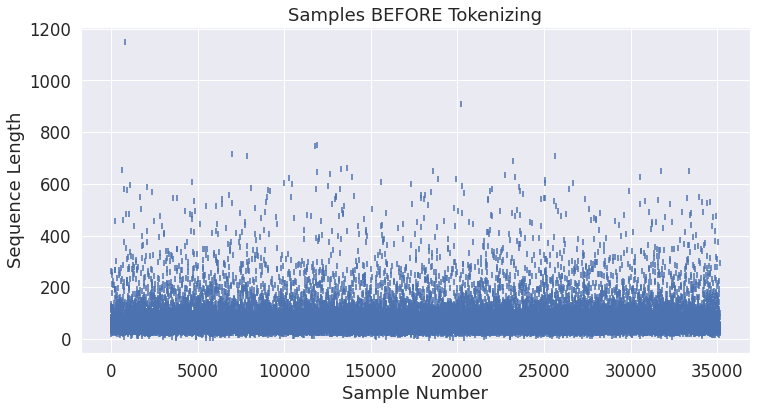

In [ ]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [ ]:
max_input_length = 400

In [ ]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:
    
    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,           
                                 add_special_tokens=True, 
                                 max_length=max_input_length,  
                                 truncation=True,     
                                 padding=False)       
                                 
    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)
    
print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 35,139 training samples...
  Tokenized 0 samples.
  Tokenized 4,000 samples.
  Tokenized 8,000 samples.
  Tokenized 12,000 samples.
  Tokenized 16,000 samples.
  Tokenized 20,000 samples.
  Tokenized 24,000 samples.
  Tokenized 28,000 samples.
  Tokenized 32,000 samples.
DONE.
    35,139 samples


In [ ]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

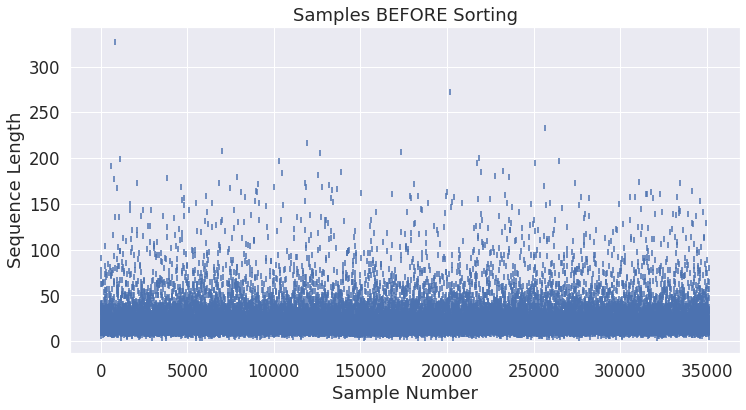

In [ ]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [ ]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [ ]:
train_samples[0:5]

[([0, 165008, 2], 0),
 ([0, 18621, 2], 0),
 ([0, 167070, 2], 0),
 ([0, 167070, 2], 0),
 ([0, 1601, 6057, 2], 0)]

In [ ]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 327


In [ ]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

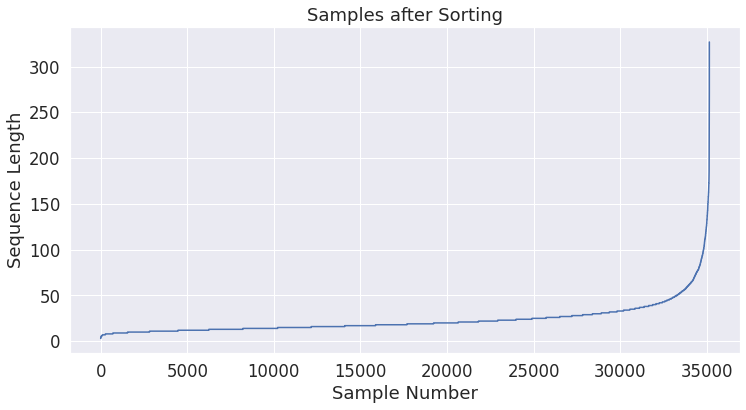

In [ ]:

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [ ]:
train_samples[0]

([0, 165008, 2], 0)

In [ ]:
batch_size = 16

In [ ]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...    
while len(train_samples) > 0:
    
    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until 
    # we get to the last batch, which may be smaller. 
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of 
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.
  Selected 500 batches.
  Selected 600 batches.
  Selected 700 batches.
  Selected 800 batches.
  Selected 900 batches.
  Selected 1,000 batches.
  Selected 1,100 batches.
  Selected 1,200 batches.
  Selected 1,300 batches.
  Selected 1,400 batches.
  Selected 1,500 batches.
  Selected 1,600 batches.
  Selected 1,700 batches.
  Selected 1,800 batches.
  Selected 1,900 batches.
  Selected 2,000 batches.
  Selected 2,100 batches.

  DONE - 2,197 batches.


In [ ]:
print(batch_ordered_sentences[0])

[[0, 1660, 116, 92, 1884, 7, 47, 58359, 4082, 92, 1884, 7, 2], [0, 46895, 15445, 154773, 140822, 2912, 3219, 31604, 12751, 81782, 218711, 44221, 2], [0, 34326, 12009, 192784, 164010, 41812, 64875, 175254, 214, 100, 14277, 54452, 2], [0, 360, 3238, 5786, 2773, 6897, 21, 1932, 71810, 9229, 193, 136981, 2], [0, 14195, 180281, 23, 4829, 658, 156, 8848, 75890, 528, 152853, 13, 2], [0, 22410, 594, 1884, 7, 285, 316, 76, 1884, 2652, 539, 208, 2], [0, 6, 22147, 111224, 2912, 82903, 13070, 2650, 39632, 47633, 44083, 101021, 2], [0, 87293, 100, 47725, 39030, 16891, 2913, 12751, 2650, 83656, 30147, 248115, 2], [0, 8053, 39, 6864, 17366, 21, 17, 206471, 315, 70, 416, 99424, 2], [0, 27989, 14, 167070, 3984, 11, 335, 177, 39, 345, 418, 228008, 2], [0, 44298, 161, 3005, 13148, 161, 98, 2606, 93340, 4393, 11, 29892, 2], [0, 17170, 6057, 62964, 60674, 1462, 35992, 5962, 1884, 3688, 5, 1468, 2], [0, 423, 19879, 307, 28905, 315, 3115, 142232, 208, 1884, 2652, 28391, 2], [0, 106023, 6864, 17366, 1263, 193

In [ ]:
batch_ordered_labels[0]

[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0]

### Padding

In [ ]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []
    
    # First, find the longest sample in the batch. 
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:
        
        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [ ]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:
    
    # For each sample...
    for s in batch:
    
        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 14,055,600
  Smart Batching: 825,248  (94.1% less)


## Load the model configuration from the transformers library using AutoConfig

In [ ]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'> 



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

## Load the model from the transformers library using AutoModel

In [ ]:
# # Load the pre-trained model for classification, passing in the `config` from
# # above.
# bert = AutoModel.from_pretrained(
#     pretrained_model_name_or_path=model_name,
#     config=config)

# print('\nModel type:', str(type(bert)))


In [ ]:
# # freeze all the parameters
# for param in bert.parameters():
#     param.requires_grad = False

## Creating a custom BERT model 

In [ ]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert        
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model  
#       outputs = self.bert(input_id,mask)
  
#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [ ]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [ ]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights) 


## Loading Optimizer

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


## Loading lr scheduler

In [ ]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [ ]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = {
    'epoch':[],
    'train_loss':[],
    'Training Time':[],
    'val_loss':[],
    'Validation Time':[],
    'train_acc':[],
    'val_acc':[]
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the 
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)
    
    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = output.loss 
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
      
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)     
       
    training_accuracy = check_accuracy(predictions,true_labels)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training Accuracy: {0:.2f}".format(training_accuracy))
    print("  Training epoch took: {:}".format(training_time))
        
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)
    val_loss,val_accuracy,validation_time = eval_model(model,py_inputs, py_attn_masks, py_labels)  
    # Record all statistics from this epoch.

    print("")
    print("  Average validation loss: {0:.2f}".format(val_loss))
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))
    print("  Validation epoch took: {:}".format(validation_time))
    
    
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training on 2,197 batches...
  Batch     200  of    2,197.    Elapsed: 0:00:34.  Remaining: 0:05:41
  Batch     400  of    2,197.    Elapsed: 0:01:09.  Remaining: 0:05:10
  Batch     600  of    2,197.    Elapsed: 0:01:45.  Remaining: 0:04:40
  Batch     800  of    2,197.    Elapsed: 0:02:21.  Remaining: 0:04:07
  Batch   1,000  of    2,197.    Elapsed: 0:02:58.  Remaining: 0:03:33
  Batch   1,200  of    2,197.    Elapsed: 0:03:34.  Remaining: 0:02:58
  Batch   1,400  of    2,197.    Elapsed: 0:04:11.  Remaining: 0:02:23
  Batch   1,600  of    2,197.    Elapsed: 0:04:46.  Remaining: 0:01:47
  Batch   1,800  of    2,197.    Elapsed: 0:05:22.  Remaining: 0:01:11
  Batch   2,000  of    2,197.    Elapsed: 0:05:59.  Remaining: 0:00:35

  Average training loss: 0.81
  Training Accuracy: 0.74
  Training epoch took: 0:06:36
Creating Smart Batches from 4,388 examples with batch size 16...

Tokenizing 4,388 samples...
  Tokenized 0 samples.
  Tokenized 400 samples.


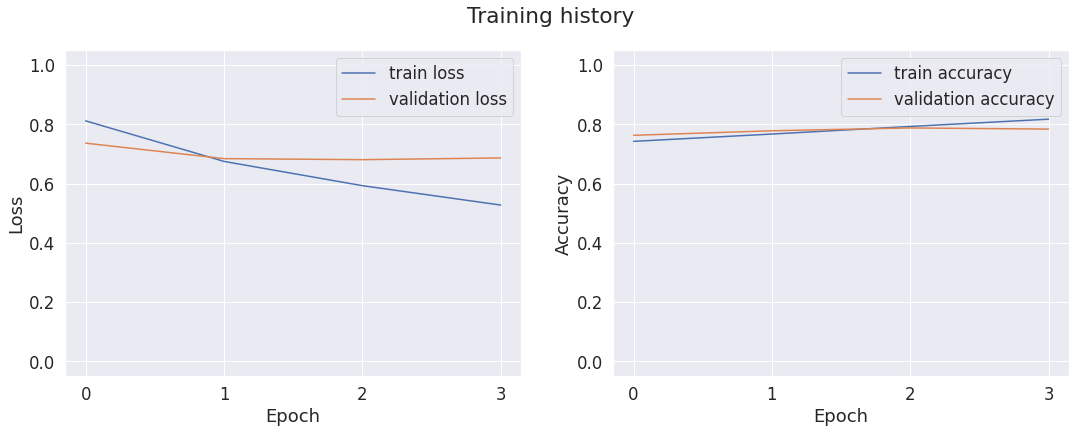

In [ ]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [ ]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 35,139 examples with batch size 16...

Tokenizing 35,139 samples...
  Tokenized 0 samples.
  Tokenized 4,000 samples.
  Tokenized 8,000 samples.
  Tokenized 12,000 samples.
  Tokenized 16,000 samples.
  Tokenized 20,000 samples.
  Tokenized 24,000 samples.
  Tokenized 28,000 samples.
  Tokenized 32,000 samples.
DONE.
    35,139 samples

    35,139 samples after sorting

Creating batches of size 16...

  DONE - Selected 2,197 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 2,197 test batches...
  Batch     200  of    2,197.    Elapsed: 0:00:05.  Remaining: 0:00:46
  Batch     400  of    2,197.    Elapsed: 0:00:09.  Remaining: 0:00:42
  Batch     600  of    2,197.    Elapsed: 0:00:14.  Remaining: 0:00:37
  Batch     800  of    2,197.    Elapsed: 0:00:19.  Remaining: 0:00:32
  Batch   1,000  of    2,197.    Elapsed: 0:00:23.  Remaining: 0:00:28
  Batch   1,200  of    2,197.    Elapsed: 0:00:28.  Remaining: 0:00:24
  Batch   1,

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [ ]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 4,388 examples with batch size 16...

Tokenizing 4,388 samples...
  Tokenized 0 samples.
  Tokenized 400 samples.
  Tokenized 800 samples.
  Tokenized 1,200 samples.
  Tokenized 1,600 samples.
  Tokenized 2,000 samples.
  Tokenized 2,400 samples.
  Tokenized 2,800 samples.
  Tokenized 3,200 samples.
  Tokenized 3,600 samples.
  Tokenized 4,000 samples.
DONE.
     4,388 samples

     4,388 samples after sorting

Creating batches of size 16...

  DONE - Selected 275 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 275 test batches...
  Batch      30  of      275.    Elapsed: 0:00:01.  Remaining: 0:00:07
  Batch      60  of      275.    Elapsed: 0:00:02.  Remaining: 0:00:05
  Batch      90  of      275.    Elapsed: 0:00:02.  Remaining: 0:00:05
  Batch     120  of      275.    Elapsed: 0:00:03.  Remaining: 0:00:04
  Batch     150  of      275.    Elapsed: 0:00:04.  Remaining: 0:00:03
  Batch     180  of      275.    Elapsed: 0:0

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

                                      precision    recall  f1-score   support

                       Not_offensive       0.86      0.93      0.89      3193
     Offensive_Targeted_Insult_Group       0.38      0.29      0.33       295
Offensive_Targeted_Insult_Individual       0.47      0.39      0.43       307
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        65
               Offensive_Untargetede       0.45      0.40      0.42       356
                           not-Tamil       0.85      0.77      0.81       172

                            accuracy                           0.78      4388
                           macro avg       0.50      0.46      0.48      4388
                        weighted avg       0.76      0.78      0.77      4388



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


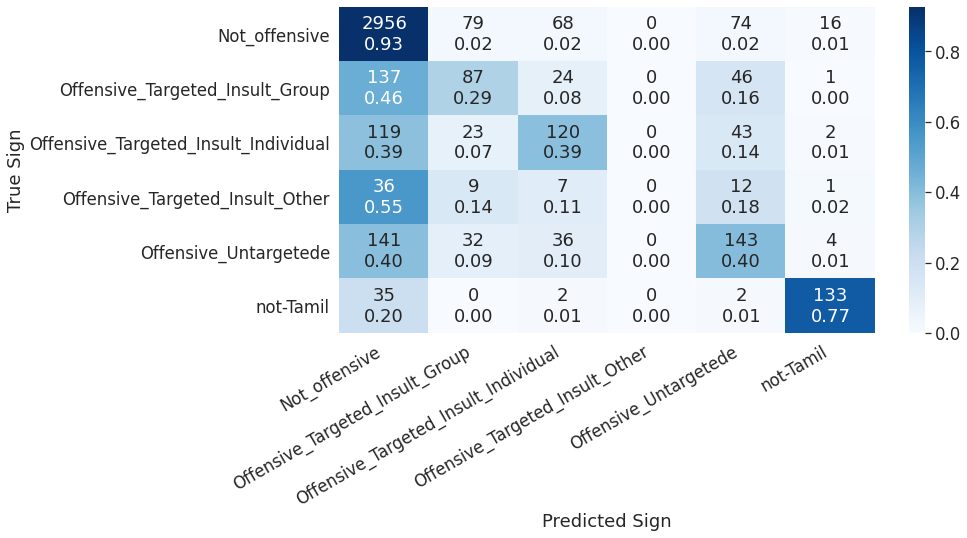

In [ ]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Saving the model

In [ ]:
torch.save(model,"./drive/MyDrive/Codalab/Offensive Language Identification/Models/XLMR_Tamil_v1")

## Loading the model

In [ ]:
model = torch.load('./drive/MyDrive/Codalab/Offensive Language Identification/Models/XLMR_Tamil_v1',map_location=device)

In [ ]:
model.cuda()

## Making Predictions on Test Set

In [ ]:
test_df_path = join(dataset_dir,'tamil_offensive_full_test.csv')
test_df = pd.read_csv(test_df_path,sep='\t')

In [ ]:
test_df

,text
0,14.12.2018 epo trailer pathutu irken ... Semay...
1,Paka thana poro movie la Enna irukunu
2,“U kena tunggu lebih lama lagi untuk tahu saya...
3,Suriya anna vera level anna mass
4,suma kaththaatha da sound over a pooda kudaath...
...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...
4388,Babu mele ko ye song sunke kuch yesa feel hua ...
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...
4390,Vijay's all movies look like same.


## Loading `test_sentences`

In [ ]:
test_sentences = test_df['text'].values 
test_ids = test_df.index.values

In [ ]:
test_ids

array([   0,    1,    2, ..., 4389, 4390, 4391])

In [ ]:
test_sentences

array(['14.12.2018 epo trailer pathutu irken ... Semaya iruku',
       'Paka thana poro movie la Enna irukunu',
       '“U kena tunggu lebih lama lagi untuk tahu saya” - chiyaan recognized',
       ...,
       'asuran= aadukalam+pudupettai+ wada chennai..yellame ore madirida...',
       "Vijay's all movies look like same.",
       'Eh Idhu 96, yaara emathuringa.. Bangam ji Bangam ji'],
      dtype=object)

In [ ]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 4,392 examples with batch size 16...

Tokenizing 4,392 samples...
  Tokenized 0 samples.
  Tokenized 400 samples.
  Tokenized 800 samples.
  Tokenized 1,200 samples.
  Tokenized 1,600 samples.
  Tokenized 2,000 samples.
  Tokenized 2,400 samples.
  Tokenized 2,800 samples.
  Tokenized 3,200 samples.
  Tokenized 3,600 samples.
  Tokenized 4,000 samples.
DONE.
     4,392 samples

     4,392 samples after sorting

Creating batches of size 16...

  DONE - Selected 275 batches.

Padding out sequences within each batch...
  DONE.


## Evaluating accuracy over test set

In [ ]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 275 test batches...
  Batch      30  of      275.    Elapsed: 0:00:01.  Remaining: 0:00:06
  Batch      60  of      275.    Elapsed: 0:00:02.  Remaining: 0:00:06
  Batch      90  of      275.    Elapsed: 0:00:02.  Remaining: 0:00:05
  Batch     120  of      275.    Elapsed: 0:00:03.  Remaining: 0:00:04
  Batch     150  of      275.    Elapsed: 0:00:04.  Remaining: 0:00:03
  Batch     180  of      275.    Elapsed: 0:00:04.  Remaining: 0:00:02
  Batch     210  of      275.    Elapsed: 0:00:05.  Remaining: 0:00:02
  Batch     240  of      275.    Elapsed: 0:00:06.  Remaining: 0:00:01
  Batch     270  of      275.    Elapsed: 0:00:07.  Remaining: 0:00:00


In [ ]:
print(y_preds)

In [ ]:
print(y_ids)

In [ ]:
le.inverse_transform(y_preds)

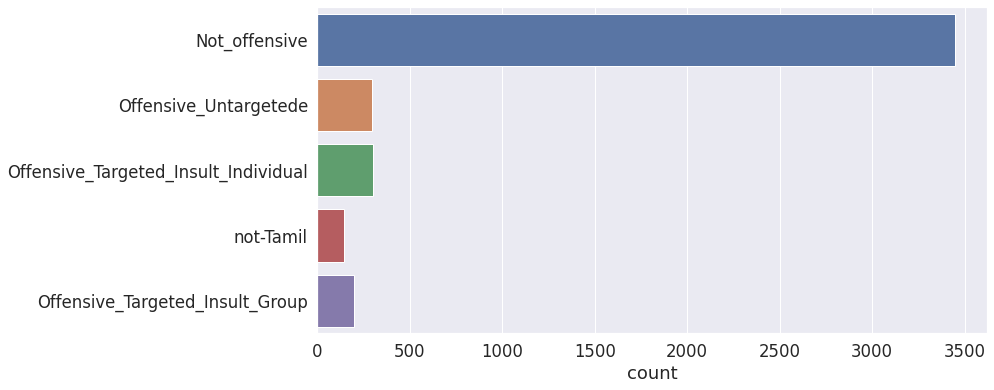

In [ ]:
sns.countplot(y =le.inverse_transform(y_preds))

In [ ]:
len(y_ids)

4392

In [ ]:
len(le.inverse_transform(y_preds))

4392

## Creating Submission DataFrame

In [ ]:
df_new = pd.DataFrame({
    'id':y_ids,
    'label':le.inverse_transform(y_preds)
})

In [ ]:
test_df['id'] = test_df.index

In [ ]:
df_new

,id,label
0,2474,Not_offensive
1,2483,Not_offensive
2,2498,Offensive_Untargetede
3,2538,Not_offensive
4,2579,Not_offensive
...,...,...
4387,808,Not_offensive
4388,736,Not_offensive
4389,3615,Not_offensive
4390,31,Not_offensive


In [ ]:
test_df

,text,id
0,14.12.2018 epo trailer pathutu irken ... Semay...,0
1,Paka thana poro movie la Enna irukunu,1
2,“U kena tunggu lebih lama lagi untuk tahu saya...,2
3,Suriya anna vera level anna mass,3
4,suma kaththaatha da sound over a pooda kudaath...,4
...,...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,4387
4388,Babu mele ko ye song sunke kuch yesa feel hua ...,4388
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,4389
4390,Vijay's all movies look like same.,4390


In [ ]:
df_f = pd.merge(test_df,df_new,on = 'id')
df_f

,text,id,label
0,14.12.2018 epo trailer pathutu irken ... Semay...,0,Not_offensive
1,Paka thana poro movie la Enna irukunu,1,Not_offensive
2,“U kena tunggu lebih lama lagi untuk tahu saya...,2,not-Tamil
3,Suriya anna vera level anna mass,3,Not_offensive
4,suma kaththaatha da sound over a pooda kudaath...,4,Offensive_Targeted_Insult_Group
...,...,...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,4387,Not_offensive
4388,Babu mele ko ye song sunke kuch yesa feel hua ...,4388,not-Tamil
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,4389,Not_offensive
4390,Vijay's all movies look like same.,4390,Not_offensive


In [ ]:
df_f = df_f[['id','text','label']]
df_f

,id,text,label
0,0,14.12.2018 epo trailer pathutu irken ... Semay...,Not_offensive
1,1,Paka thana poro movie la Enna irukunu,Not_offensive
2,2,“U kena tunggu lebih lama lagi untuk tahu saya...,not-Tamil
3,3,Suriya anna vera level anna mass,Not_offensive
4,4,suma kaththaatha da sound over a pooda kudaath...,Offensive_Targeted_Insult_Group
...,...,...,...
4387,4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,Not_offensive
4388,4388,Babu mele ko ye song sunke kuch yesa feel hua ...,not-Tamil
4389,4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,Not_offensive
4390,4390,Vijay's all movies look like same.,Not_offensive


## Saving Submission DataFrame

In [ ]:
path = './drive/MyDrive/Codalab/Offensive Language Identification/SubmissionFiles'

In [ ]:
df_f.to_csv(join(path,'xlmr_tamil.csv'),index=False)